# Preprocessing & analysis of Kanye West's lyrics

In [2]:
import json
import nltk
import re
import contractions
from collections import Counter
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
import gensim
import gensim.corpora as corpora
from gensim.models import LdaMulticore
import pyLDAvis.gensim
from sentence_transformers import SentenceTransformer, util
from IPython.display import display
import statistics

import numpy as np

In [3]:
album_list = ["The College Dropout", "Late Registration", "Graduation", "808s & Heartbreak", "My Beautiful Dark Twisted Fantasy", "Yeezus",
              "The Life of Pablo", "Ye", "Jesus Is King", "Donda", "Kids See Ghosts", "Watch The Throne"] # list of all Kanye's studio albums
albums = {"The College Dropout":"", "Late Registration":"", "Graduation":"", "808s & Heartbreak":"", "My Beautiful Dark Twisted Fantasy":"", "Yeezus":"",
          "The Life of Pablo":"", "Ye":"", "Jesus Is King":"", "Donda":"", "Kids See Ghosts":"", "Watch The Throne":""} # dictionary, key is studio album, value will be lyrics of all songs combined into one document

adlibs = ["get", "oh", "uh", "huh", "heh", "yeah", "yah", "uhuh",
          "ayy", "ooh", "woah", "hmm", "hm", 'mm', 'mmm', "bam", "duh", "mmh", "nah", "mhm"] #adlibs, to be added to stopword list

with open("data/songs.json", "r", encoding="utf-8") as file:
    lyrics = json.load(file)
full_lyrics = lyrics


In [4]:
def preprocess():
    """Preprocess the lyrics' dictionary. """
    for song in lyrics: # iterate through all songs
        expanded_words = []
        text = lyrics[song]["lyrics"].lower() # put everything into lowercase
        text = re.sub("\n", " ", text) # remove newlines
        text = re.sub('[*,\.!?]', '', text) # remove punctuation and other chars

        for word in text.split():
                expanded_words.append(contractions.fix(word)) # remove contractions i.e. we'll -> we will
        text = expanded_words
        text = ' '.join(text) # join back to string
        text = nltk.WordPunctTokenizer().tokenize(text) # tokenize
        text = [nltk.stem.WordNetLemmatizer().lemmatize(token, pos='v') for token in text if len(token)>1] # lemmatize verbs
        text = [nltk.stem.WordNetLemmatizer().lemmatize(token, pos='n') for token in text if len(token)>1] # lemmatize nouns
        text = [nltk.stem.WordNetLemmatizer().lemmatize(token, pos='a') for token in text if len(token)>1] # lemmatize adjectives
        stopword_list = nltk.corpus.stopwords.words("english") # initialize stopword list
        stopword_list.extend(adlibs) # add adlibs into the stopword list
        removed_stopwords = []
        for word in text: # iterate through words, if the word is not in stopwords, keep it. Remov otherwise
            if word not in stopword_list:
                removed_stopwords.append(word)
        text = removed_stopwords
        lyrics[song]["lyrics"] = text # replace original text with preprocessed text

<>:7: DeprecationWarning: invalid escape sequence '\.'
<>:7: DeprecationWarning: invalid escape sequence '\.'
C:\Users\vojta\AppData\Local\Temp\ipykernel_27992\3420235418.py:7: DeprecationWarning: invalid escape sequence '\.'
  text = re.sub('[*,\.!?]', '', text) # remove punctuation and other chars


In [5]:
def generate_wordcloud(album):
    """Method to generate wordclouds with 200 most used words on each album.
    Not really useful for any of the task, just thought it might be interesting """
    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='white',
                          min_font_size = 10,
                          collocations=False,
                          random_state=1).generate(albums[album],)
    plt.figure(1, figsize = (10, 10), facecolor = None)
    plt.axis("off")
    plt.imshow(wordcloud)
    plt.savefig(f'{album}.png') # save as png

In [6]:
def get_individual_albums(texts):
    """Method to gather lyrics from all songs of each album and connect them into one large document"""
    for album in album_list:
        for song in lyrics:
            if texts[song]["album"] == album:
              albums[album] = albums[album] + ' '.join(texts[song]["lyrics"])

In [7]:
preprocess()
get_individual_albums(lyrics)

In [8]:
# for album in albums: # iterate through album list and generate wordclouds
#     generate_wordcloud(album)

### TF- IDF Vectorization
TF-IDF vectorization lets us use the dataset for clustering

In [9]:
for song in lyrics: # join lyrics into a string instead of a list for each song
    lyrics[song]["lyrics"] = " ".join(lyrics[song]["lyrics"])
df_lyrics = pd.DataFrame.from_dict(lyrics, orient="index") # create a dataframe from dict

In [10]:
df_lyrics.head()

,album,lyrics
Intro,The College Dropout,kanye talk minute faculty member wonderin coul...
We Don’t Care,The College Dropout,perfect song kid sing people drug dealin stack...
Graduation Day,The College Dropout,fuck kanye tell shit kid give muthafuckin grad...
All Falls Down,The College Dropout,fall real one baby tellin fall chi town stand ...
I’ll Fly Away,The College Dropout,one glad morning life fly away land joy shall ...


In [11]:
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95) # used metaparameters as advised on stackoverflow
X = vectorizer.fit_transform(df_lyrics['lyrics'])

### Clustering
Aim is to create clusters of songs that use similar words. This uses the bag of words approach and doesn't really mean that the songs are thematically similar, although it could.

In [12]:
kmeans = KMeans(n_clusters=5, random_state=420) # decided to go with 5 clusters, was not able to perform k-elbow test to determine the best. Random state for replicability
kmeans.fit(X) # fit data into our kmeans model

C:\SDKs\kanye_lyrics_venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=5, random_state=420)

In [13]:
df_lyrics['cluster'] = kmeans.labels_

In [14]:
def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(X.todense()).groupby(kmeans.labels_).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names_out() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score

# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(X.toarray())
# save our two dimensions into x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]
df_lyrics['x0'] = x0
df_lyrics['x1'] = x1

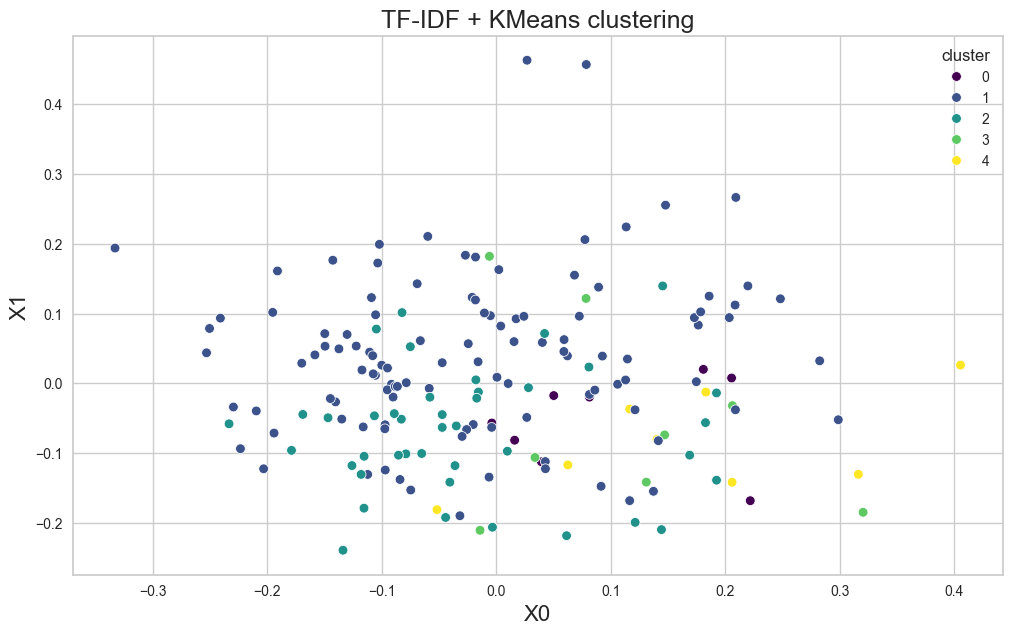

In [15]:
# set image size
plt.figure(figsize=(12, 7))
# set a title
plt.title("TF-IDF + KMeans clustering", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=df_lyrics, x='x0', y='x1', hue='cluster', palette="viridis")
plt.show()

### From the top 10 terms in each cluster from the tf-idf matrix we can assume what the songs in each cluster are about
Cluster 0: spiritual songs with various mentions of the holy trinity and Kanye's mother Donda
Cluster 1: songs that often mention love and feelings
Cluster 2: songs about women, lots of profanities and other stereotypical rapper lyrics
Cluster 3: songs with mentions of god, devil, possibly discussing Kanye's relationship with god
Cluster 4: songs with expressions of various feelings, possibly personal struggle

In [16]:
get_top_keywords(20)


Cluster 0
open,real,life,could,news,like,movin,cool,mean,keep,wake,ring,wide,know,forward,much,dream,true,find,wonder

Cluster 1
right,good,need,tell,nigga,take,man,feel,never,one,god,love,want,say,make,see,let,like,go,know

Cluster 2
make,could,shit,tell,gon,would,say,want,right,night,go,baby,need,bitch,cannot,love,like,fuck,know,nigga

Cluster 3
cannot,god,killer,go,guess,post,like,really,tell,take,five,kanye,jail,summer,hey,tonight,hold,honest,miss,donda

Cluster 4
tongue,west,front,jesus,light,forever,street,away,bow,every,life,knee,mr,wit,land,outta,fly,glory,shall,morning


In [17]:
df_lyrics["cluster"].value_counts() # show number of songs assigned to each cluster

cluster
1    111
2     41
4      8
0      8
3      8
Name: count, dtype: int64

In [18]:
df_lyrics[df_lyrics["cluster"] == 0]

,album,lyrics,cluster,x0,x1
Back to Basics,Late Registration,let take back basic shit bad converse need new...,0,0.016135,-0.081382
I Wonder,Graduation,find dream come true wonder know mean mean won...,0,0.050310,-0.017490
Good Night,Graduation,sure anymore ymore knock door door face know j...,0,0.081474,-0.019684
Bad News,808s & Heartbreak,know wait wait dream never come true know wait...,0,0.039526,-0.112267
Dark Fantasy,My Beautiful Dark Twisted Fantasy,might think peep scene real one far mean water...,0,-0.003756,-0.056788
Low Lights,The Life of Pablo,want give testimony life good know tell love m...,0,0.181009,0.020052
Frank’s Track,The Life of Pablo,ring ring burn cave blacken dark mix flesh lig...,0,0.221971,-0.168005
Reborn,Kids See Ghosts,wide awake wide awake wide awake hey wide awak...,0,0.205652,0.007647


In [19]:
df_lyrics[df_lyrics["cluster"] == 1]

,album,lyrics,cluster,x0,x1
We Don’t Care,The College Dropout,perfect song kid sing people drug dealin stack...,1,-0.130211,0.069991
All Falls Down,The College Dropout,fall real one baby tellin fall chi town stand ...,1,-0.110488,0.044725
Spaceship,The College Dropout,work grave shift make shit wish could buy spac...,1,-0.108924,0.122814
Jesus Walks,The College Dropout,war war terrorism racism war jesus walk god sh...,1,-0.018033,0.180826
Never Let Me Down,The College Dropout,baby hahahaha turn motherfuckin music come tru...,1,-0.101983,0.199080
...,...,...,...,...,...
Murder to Excellence,Watch The Throne,bloody murder murder murder bloody murder murd...,1,0.003981,0.082077
Made in America,Watch The Throne,bring darkness sweet king martin sweet queen c...,1,0.092798,0.039061
Illest Motherfucker Alive,Watch The Throne,damn 1985 white lamborghini countach two need ...,1,-0.112222,-0.130422
H·A·M,Watch The Throne,good week ago nigga feel theyself watch throne...,1,-0.223375,-0.093570


In [20]:
df_lyrics[df_lyrics["cluster"] == 2]

,album,lyrics,cluster,x0,x1
Intro,The College Dropout,kanye talk minute faculty member wonderin coul...,2,0.144398,-0.209403
Graduation Day,The College Dropout,fuck kanye tell shit kid give muthafuckin grad...,2,-0.065039,-0.100422
Breathe In Breathe Out,The College Dropout,breathe breathe ice pull sleeve push big truck...,2,-0.168900,-0.044501
Late,Late Registration,little girl ha ha ha ha please stop cry late b...,2,-0.078852,-0.100979
Stronger,Graduation,work make make hard good fast strong th kill m...,2,-0.015489,-0.012382
Can’t Tell Me Nothing,Graduation,la la la la wait til money right dream could b...,2,-0.104658,0.077763
Flashing Lights,Graduation,flash light light light flash light light ligh...,2,-0.047121,-0.044740
Heartless,808s & Heartbreak,night hear talk cold story ever tell somewhere...,2,0.028238,-0.006151
Coldest Winter,808s & Heartbreak,lonely night start fade lonely night start fad...,2,0.192500,-0.138619
Pinocchio Story,808s & Heartbreak,wise man say wise man say wise man say never f...,2,-0.082222,0.101301


In [21]:
df_lyrics[df_lyrics["cluster"] == 3]

,album,lyrics,cluster,x0,x1
Say You Will,808s & Heartbreak,would make call blue awake sleep le june miss ...,3,0.131173,-0.141400
Pt. 2,The Life of Pablo,faaaaaaaa perfect faaaaaaaa faaaaaaaa faaaaaaa...,3,-0.014084,-0.210362
I Love Kanye,The Life of Pablo,miss old kanye straight go kanye chop soul kan...,3,0.033938,-0.106110
Donda Chant,Donda,donda donda donda donda donda donda donda dond...,3,0.320544,-0.184603
Jail,Donda,take want take everything take want take want ...,3,0.078506,0.121564
Junya,Donda,junya watanabe wri wri junya watanabe wri wri ...,3,0.206403,-0.031886
Jail pt 2,Donda,take want take everything take want take want ...,3,-0.005880,0.181904
Junya pt 2,Donda,junya watanabe wri wri junya watanabe wri wri ...,3,0.147184,-0.073826


In [22]:
df_lyrics[df_lyrics["cluster"] == 4]

,album,lyrics,cluster,x0,x1
I’ll Fly Away,The College Dropout,one glad morning life fly away land joy shall ...,4,0.316389,-0.130246
Wake Up Mr. West,Late Registration,ho ho ho know gon see know gon see know gon se...,4,0.062617,-0.116793
Good Morning,Graduation,uhh uhh uhh uhh good morning good morning good...,4,0.116671,-0.036743
Barry Bonds,Graduation,wait people pay paper damn cannot stand want s...,4,-0.051701,-0.180917
Street Lights,808s & Heartbreak,let know still time grow thing always set ston...,4,0.140451,-0.080181
Everything We Need,Jesus Is King,begin storm inside lay land ah morning light w...,4,0.206104,-0.141639
Jesus Is Lord,Jesus Is King,every knee shall bow every tongue confess jesu...,4,0.405630,0.026124
Donda,Donda,forever hear forever forever forever glory glo...,4,0.183158,-0.012462


# Topic modelling
The goal of this task is to identify the most popular topics accross all of Kanye's lyrics

In [23]:
lyric_list = [ x["lyrics"].split() for x in lyrics.values()] #
bigram = gensim.models.Phrases(lyric_list)

In [24]:
lyric_dict = corpora.Dictionary(lyric_list) # create a disctionary from all songs' lyrics
texts = lyric_list
texts = [bigram[line] for line in texts]
corpus = [lyric_dict.doc2bow(text) for text in texts] # create corpus

In [25]:
lda_model = LdaMulticore(corpus=corpus, id2word=lyric_dict, num_topics=10, random_state=420) # lda model with selected attributes, num_topics = 10, random_state=420 for replicability

In [26]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, corpus, lyric_dict) # only viable to visualize that i found
# if it throws an rror, it needs pandas <2.0.0. due to a bug

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.011917  0.004848       1        1  24.793118
3     -0.023433 -0.017136       2        1  18.756100
7     -0.009402 -0.005434       3        1  14.029251
5     -0.018686  0.016249       4        1  10.335647
1      0.006486  0.014506       5        1   9.592851
6     -0.003144  0.010449       6        1   8.856433
2      0.012638 -0.000073       7        1   4.146023
8      0.006643  0.004252       8        1   4.063450
9      0.008736 -0.030309       9        1   3.260791
4      0.032081  0.002648      10        1   2.166338, topic_info=       Term        Freq       Total Category  logprob  loglift
105    know  677.000000  677.000000  Default  30.0000  30.0000
11     love  237.000000  237.000000  Default  29.0000  29.0000
108    like  632.000000  632.000000  Default  28.0000  28.0000
121   nigga  310.000000  310.000000  Default  27.0000  27.0000
86       go  528.000000  528.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
45   cannot    2.756125  193.067784  Topic10  -5.6865  -0.4171
77     feel    2.676879  213.223394  Topic10  -5.7157  -0.5456
300    need    2.644512  225.048200  Topic10  -5.7279  -0.6117
2     could    2.419080  173.053217  Topic10  -5.8170  -0.4381
219   right    2.408426  234.481208  Topic10  -5.8214  -0.7463

[774 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
3625      3  0.181588    300
3625      5  0.544765    300
3625      7  0.181588    300
3626      3  0.423817    500
3626      5  0.423817    500
...     ...       ...    ...
2867      4  0.220377  ymore
2867      5  0.440754  ymore
2785      3  0.245624  zonin
2785      5  0.491249  zonin
4942      4  0.635481  еmpty

[1676 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 8, 6, 2, 7, 3, 9, 10, 5])

### Similarity analysis
Goal is to compare individual songs accross Kanye's discography and find the most similar ones. I will be comparing two albums at a time.
As comparing all songs against each other would be too tedious to run, I decided to compary only a selection of albums.

In [27]:
model = SentenceTransformer('all-mpnet-base-v2') # selected a model that was reported as best performing on sentence-transformer documentation

In [28]:
def remove_adlibs(text):
    """Remove adlibs"""
    removed_adlibs = []
    for word in text.split(" "):
        if word not in adlibs:
            removed_adlibs.append(word)
    return removed_adlibs

In [29]:
def preprocess_sim(album):
    processed_songs = [re.sub("[\n()]"," ",full_lyrics[x]["lyrics"]) for x in full_lyrics if full_lyrics[x]["album"] == album] # remove \n and ()

    processed_songs= [remove_adlibs(x) for x in processed_songs] # remove adlibs
    song_names = [x for x in full_lyrics if full_lyrics[x]["album"] == album] # get song names
    return processed_songs, song_names

In [30]:
def similarity_analysis(album1, album2):
    songs_1, song_names_1 = preprocess_sim(album1)
    songs_2, song_names_2 = preprocess_sim(album2)

    embeddings1 = model.encode(songs_1, convert_to_tensor=True) # create embeddings
    embeddings2 = model.encode(songs_2, convert_to_tensor=True) # create embeddings
    cosine_scores = util.cos_sim(embeddings1, embeddings2) # compute cosine similarity
    cosine_scores = pd.DataFrame(cosine_scores.numpy())
    cosine_scores.rename(index=dict(zip(range(len(song_names_1)),song_names_1)), inplace=True)
    cosine_scores.rename(columns=dict(zip(range(len(song_names_2)),song_names_2)), inplace=True)
    cosine_scores = cosine_scores.where(cosine_scores < 0.99, None)
    sns.heatmap(cosine_scores, xticklabels=song_names_2, yticklabels=song_names_1, cmap="viridis")
    max_row_index, max_col_index = (cosine_scores.where(cosine_scores == cosine_scores.max().max()).stack().index.values[0])
    min_row_index, min_col_index = (cosine_scores.where(cosine_scores == cosine_scores.min().min()).stack().index.values[0])
    print(f"Most similar songs from {album1} and {album2}: {max_row_index} x {max_col_index} = {cosine_scores.max().max()}")
    print(f"Least similar songs from {album1} and {album2}: {min_row_index} x {min_col_index} = {cosine_scores.min().min()}")
    print(f"Average similarity of songs from {album1} and {album2}: {np.nanmean(cosine_scores)}")


Most similar songs from My Beautiful Dark Twisted Fantasy and Graduation: All of the Lights x Flashing Lights = 0.7092580795288086
Least similar songs from My Beautiful Dark Twisted Fantasy and Graduation: So Appalled x Good Night = 0.052654873579740524
Average similarity of songs from My Beautiful Dark Twisted Fantasy and Graduation: 0.22238753736019135


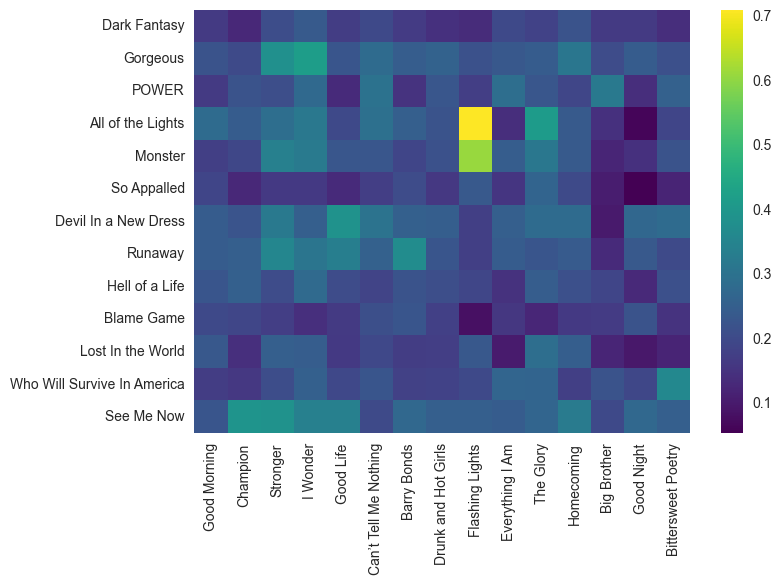

In [31]:
similarity_analysis("My Beautiful Dark Twisted Fantasy", "Graduation")

Most similar songs from Ye and Kids See Ghosts: Wouldn’t Leave x Feel the Love = 0.5155952572822571
Least similar songs from Ye and Kids See Ghosts: Yikes x Reborn = 0.08707161992788315
Average similarity of songs from Ye and Kids See Ghosts: 0.23782114684581757


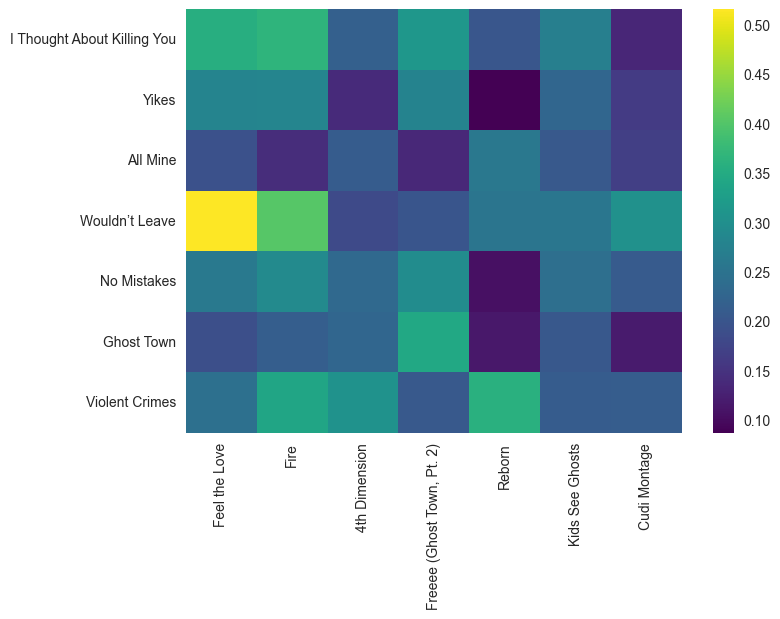

In [32]:
similarity_analysis("Ye", "Kids See Ghosts")

Most similar songs from The Life of Pablo and The Life of Pablo: No More Parties In LA x Saint Pablo = 0.5119028091430664
Least similar songs from The Life of Pablo and The Life of Pablo: Famous x No More Parties In LA = 0.03846830874681473
Average similarity of songs from The Life of Pablo and The Life of Pablo: 0.21062271296977997


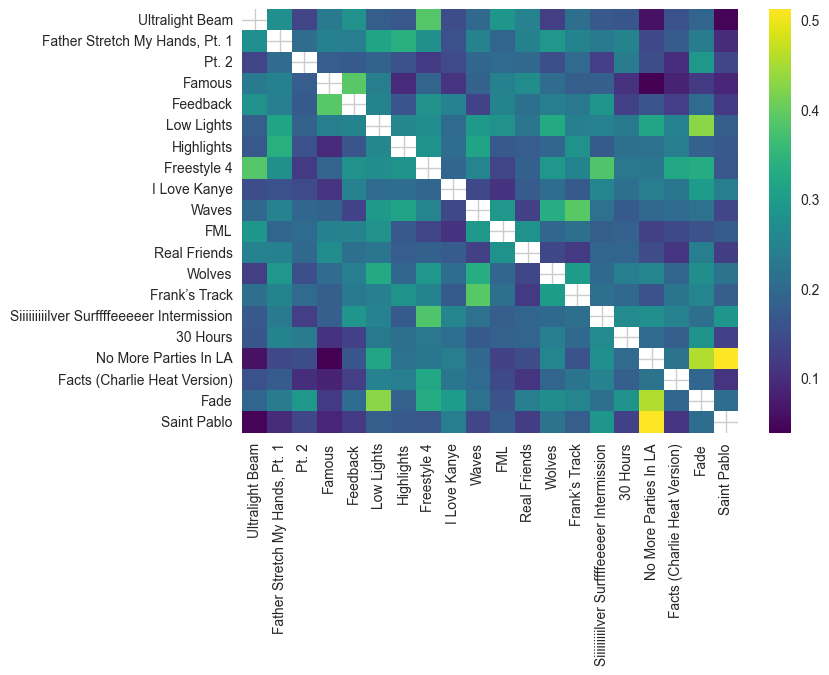

In [33]:
similarity_analysis("The Life of Pablo", "The Life of Pablo")

Most similar songs from My Beautiful Dark Twisted Fantasy and My Beautiful Dark Twisted Fantasy: All of the Lights x Monster = 0.6277158856391907
Least similar songs from My Beautiful Dark Twisted Fantasy and My Beautiful Dark Twisted Fantasy: POWER x Blame Game = 0.052149415016174316
Average similarity of songs from My Beautiful Dark Twisted Fantasy and My Beautiful Dark Twisted Fantasy: 0.23459091782569885


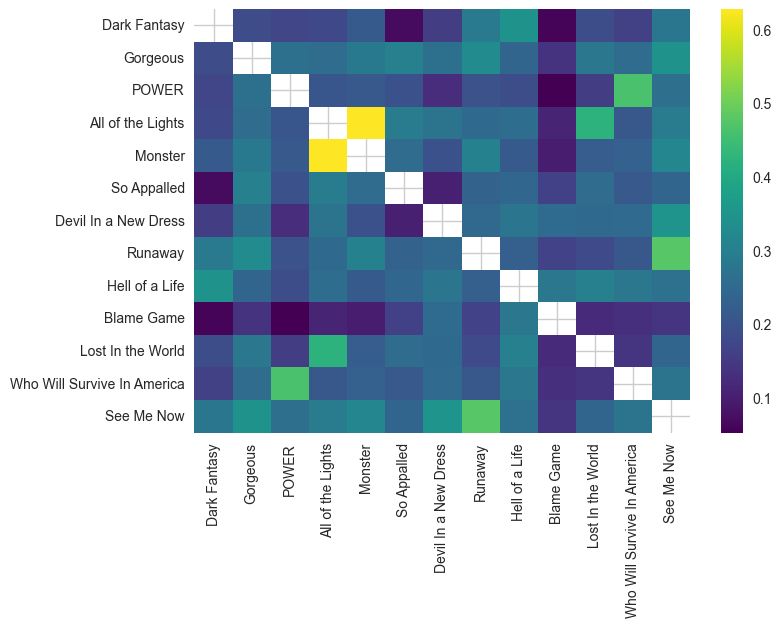

In [34]:
similarity_analysis("My Beautiful Dark Twisted Fantasy", "My Beautiful Dark Twisted Fantasy")

# Collocation analysis of highly ranked words
Goal of this task is to find how the highest-ranking words for each album are collocated and what their most common neighbours are

In [35]:
# colText = nltk.Text(albums[""].split())
# colText.collocations(10)
df_lyrics = pd.DataFrame.from_dict(albums, orient="index") # i use them all connected, given the threshold is at least 5 occurences, the collocation occuring on the end of one song and the beginning of another one should mess with my results
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True) # vectorize
tfidf_vector  = tfidf_vectorizer.fit_transform(df_lyrics[0]) # fit
tfidf_vector.toarray()
tfidf_df = pd.DataFrame(tfidf_vector.toarray(), index=df_lyrics.index, columns=tfidf_vectorizer.get_feature_names_out()) # create matrix itself

tfidf_df = tfidf_df.stack().reset_index()
tfidf_df = tfidf_df.rename(columns={0:'tfidf', 'level_0': 'album','level_1': 'term', 'level_2': 'term'})
display(tfidf_df)
top_5 = tfidf_df.sort_values(by=['album','tfidf'], ascending=[True,False]).groupby(['album']).head(5)

#we extract top 5 most important words in each album
top5_dropout = top_5[top_5["album"] == "The College Dropout"]
top5_registration = top_5[top_5["album"] == "Late Registration"]
top5_graduation = top_5[top_5["album"] == "Graduation"]
top5_808s = top_5[top_5["album"] == "808s & Heartbreak"]
top5_mbdtf = top_5[top_5["album"] == "My Beautiful Dark Twisted Fantasy"]
top5_yeezus = top_5[top_5["album"] == "Yeezus"]
top5_tlop = top_5[top_5["album"] == "The Life of Pablo"]
top5_ye = top_5[top_5["album"] == "Ye"]
top5_jik = top_5[top_5["album"] == "Jesus Is King"]
top5_donda = top_5[top_5["album"] == "Donda"]
top5_ksg = top_5[top_5["album"] == "Kids See Ghosts"]
top5_wtt = top_5[top_5["album"] == "Watch The Throne"]


# test.loc[test["bmi"] < 18.5, "healthy_weight"] = -1

,album,term,tfidf
0,The College Dropout,03,0.000000
1,The College Dropout,05,0.000000
2,The College Dropout,106,0.019856
3,The College Dropout,11,0.041670
4,The College Dropout,12,0.033619
...,...,...,...
68023,Watch The Throne,zöld,0.000000
68024,Watch The Throne,ándale,0.000000
68025,Watch The Throne,ölén,0.000000
68026,Watch The Throne,úgy,0.000000


In [36]:
top5_ksg

,album,term,tfidf
58618,Kids See Ghosts,forward,0.174859
58707,Kids See Ghosts,gat,0.168636
58677,Kids See Ghosts,ga,0.164212
60715,Kids See Ghosts,reborn,0.136374
59981,Kids See Ghosts,movin,0.133091


In [37]:
def find_collocations(top5):
    album = list(top5["album"])[0]
    terms = top5["term"]
    bigram_measures = nltk.collocations.BigramAssocMeasures()

    for word in terms:

        term_filter = lambda *w: word not in w
        finder = nltk.collocations.BigramCollocationFinder.from_words(albums[album].split(), window_size = 2)

        finder.apply_freq_filter(5)
        finder.apply_ngram_filter(term_filter)

        display(f"Most common bigrams for {word}: ")
        display(finder.ngram_fd)

In [38]:
find_collocations(top5_mbdtf)

'Most common bigrams for ridiculous: '

FreqDist({('fuckin', 'ridiculous'): 20, ('ridiculous', 'fuckin'): 9})

'Most common bigrams for concert: '

FreqDist({('hand', 'concert'): 9, ('concert', 'need'): 6})

'Most common bigrams for toast: '

FreqDist({('let', 'toast'): 12})

'Most common bigrams for slowly: '

FreqDist({('feel', 'slowly'): 6, ('slowly', 'drift'): 6})

'Most common bigrams for motherfuckin: '

FreqDist({('motherfuckin', 'monster'): 9, ('know', 'motherfuckin'): 7})

In [39]:
find_collocations(top5_ye)

'Most common bigrams for someday: '

FreqDist({})

'Most common bigrams for genie: '

FreqDist({('genie', 'bottle'): 5})

'Most common bigrams for menacin: '

FreqDist({('could', 'menacin'): 6, ('menacin', 'frightenin'): 6})

'Most common bigrams for scare: '

FreqDist({('sometimes', 'scare'): 6})

'Most common bigrams for mistake: '

FreqDist({('make', 'mistake'): 10, ('mistake', 'girl'): 10})